In [49]:
from pathlib import Path
import json
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
results = pd.read_csv("exp_results.csv")
results

,text_method,img_method,classif_method,f1_score
0,resnet50_features,bag_of_words,LogisticRegression,0.67489
1,resnet50_features,tf_idf,LogisticRegression,0.63171
2,resnet50_features,spacy_approach,LogisticRegression,0.63050
3,resnet50_features,bag_of_words,CatBoostClassifier,0.57421
4,resnet50_features,tf_idf,CatBoostClassifier,0.57266
5,resnet50_features,spacy_approach,CatBoostClassifier,0.59685


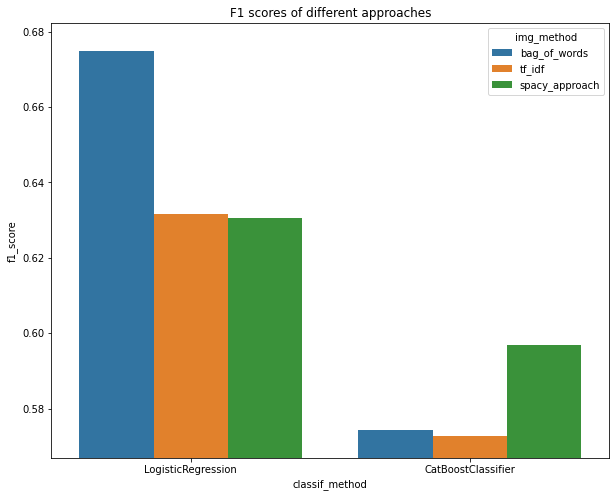

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=results, x="classif_method", y="f1_score", hue="img_method", ax=ax)
ax.set_ylim(results.f1_score.min() * 0.99, results.f1_score.max() * 1.011)
ax.set_title("F1 scores of different approaches")
plt.show()

In [41]:
data_dir = Path("data")
embeds_dir = Path("embeddings")

movie_info = pd.read_csv(data_dir / "movie_info.csv")
movie_info["genres"] = movie_info["genres"].map(lambda x: json.loads(x.replace("\'", "\"")))

classes = ["Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", "Documentary", "Drama",
            "Family", "Fantasy", "Film-Noir", "History", "Horror", "Music", "Musical", "Mystery",
            "Romance", "Sci-Fi", "Short", "Sport", "Superhero", "Thriller", "War", "Western"]

for genre in classes:
    movie_info[genre] = movie_info["genres"].map(lambda x: genre in x).astype(int)
len(movie_info)

4702

In [40]:
movie_info[["title", "plot", "genres"]].isna().sum()

title        0
plot      1405
genres       0
dtype: int64

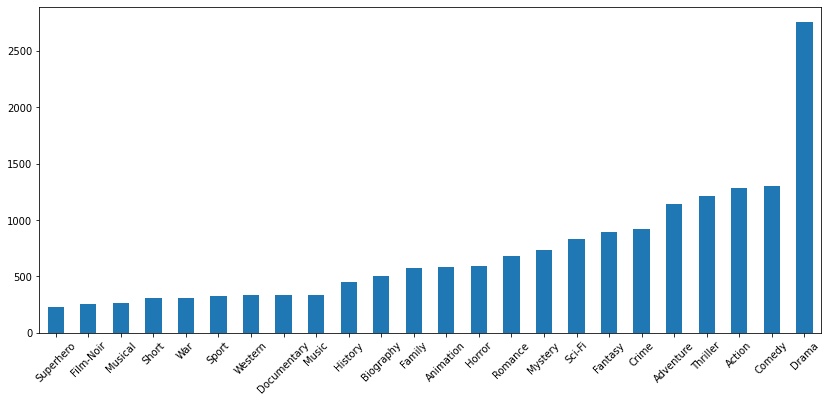

In [34]:
fig, ax = plt.subplots(figsize=(14, 6))
movie_info[classes].sum().sort_values().plot.bar(ax=ax)
plt.xticks(rotation=45)
plt.show()

# Feature importance

In [46]:
tm_title_embeds = np.load(embeds_dir / f"spacy_approach_title.npy")
tm_plot_embeds = np.load(embeds_dir / f"spacy_approach_plot.npy")
image_embeds = np.load(embeds_dir / f"resnet50_features.npy")

In [47]:
X = np.column_stack([image_embeds, tm_title_embeds, tm_plot_embeds])
y = movie_info[classes].values

In [48]:
from catboost import CatBoostRegressor

In [51]:
models = [CatBoostRegressor(random_state=0, silent=True, iterations=100) for _ in range(len(classes))]
for i in tqdm(range(len(models))):
    models[i].fit(X, y[:, i])

100%|██████████| 24/24 [10:54<00:00, 27.27s/it]


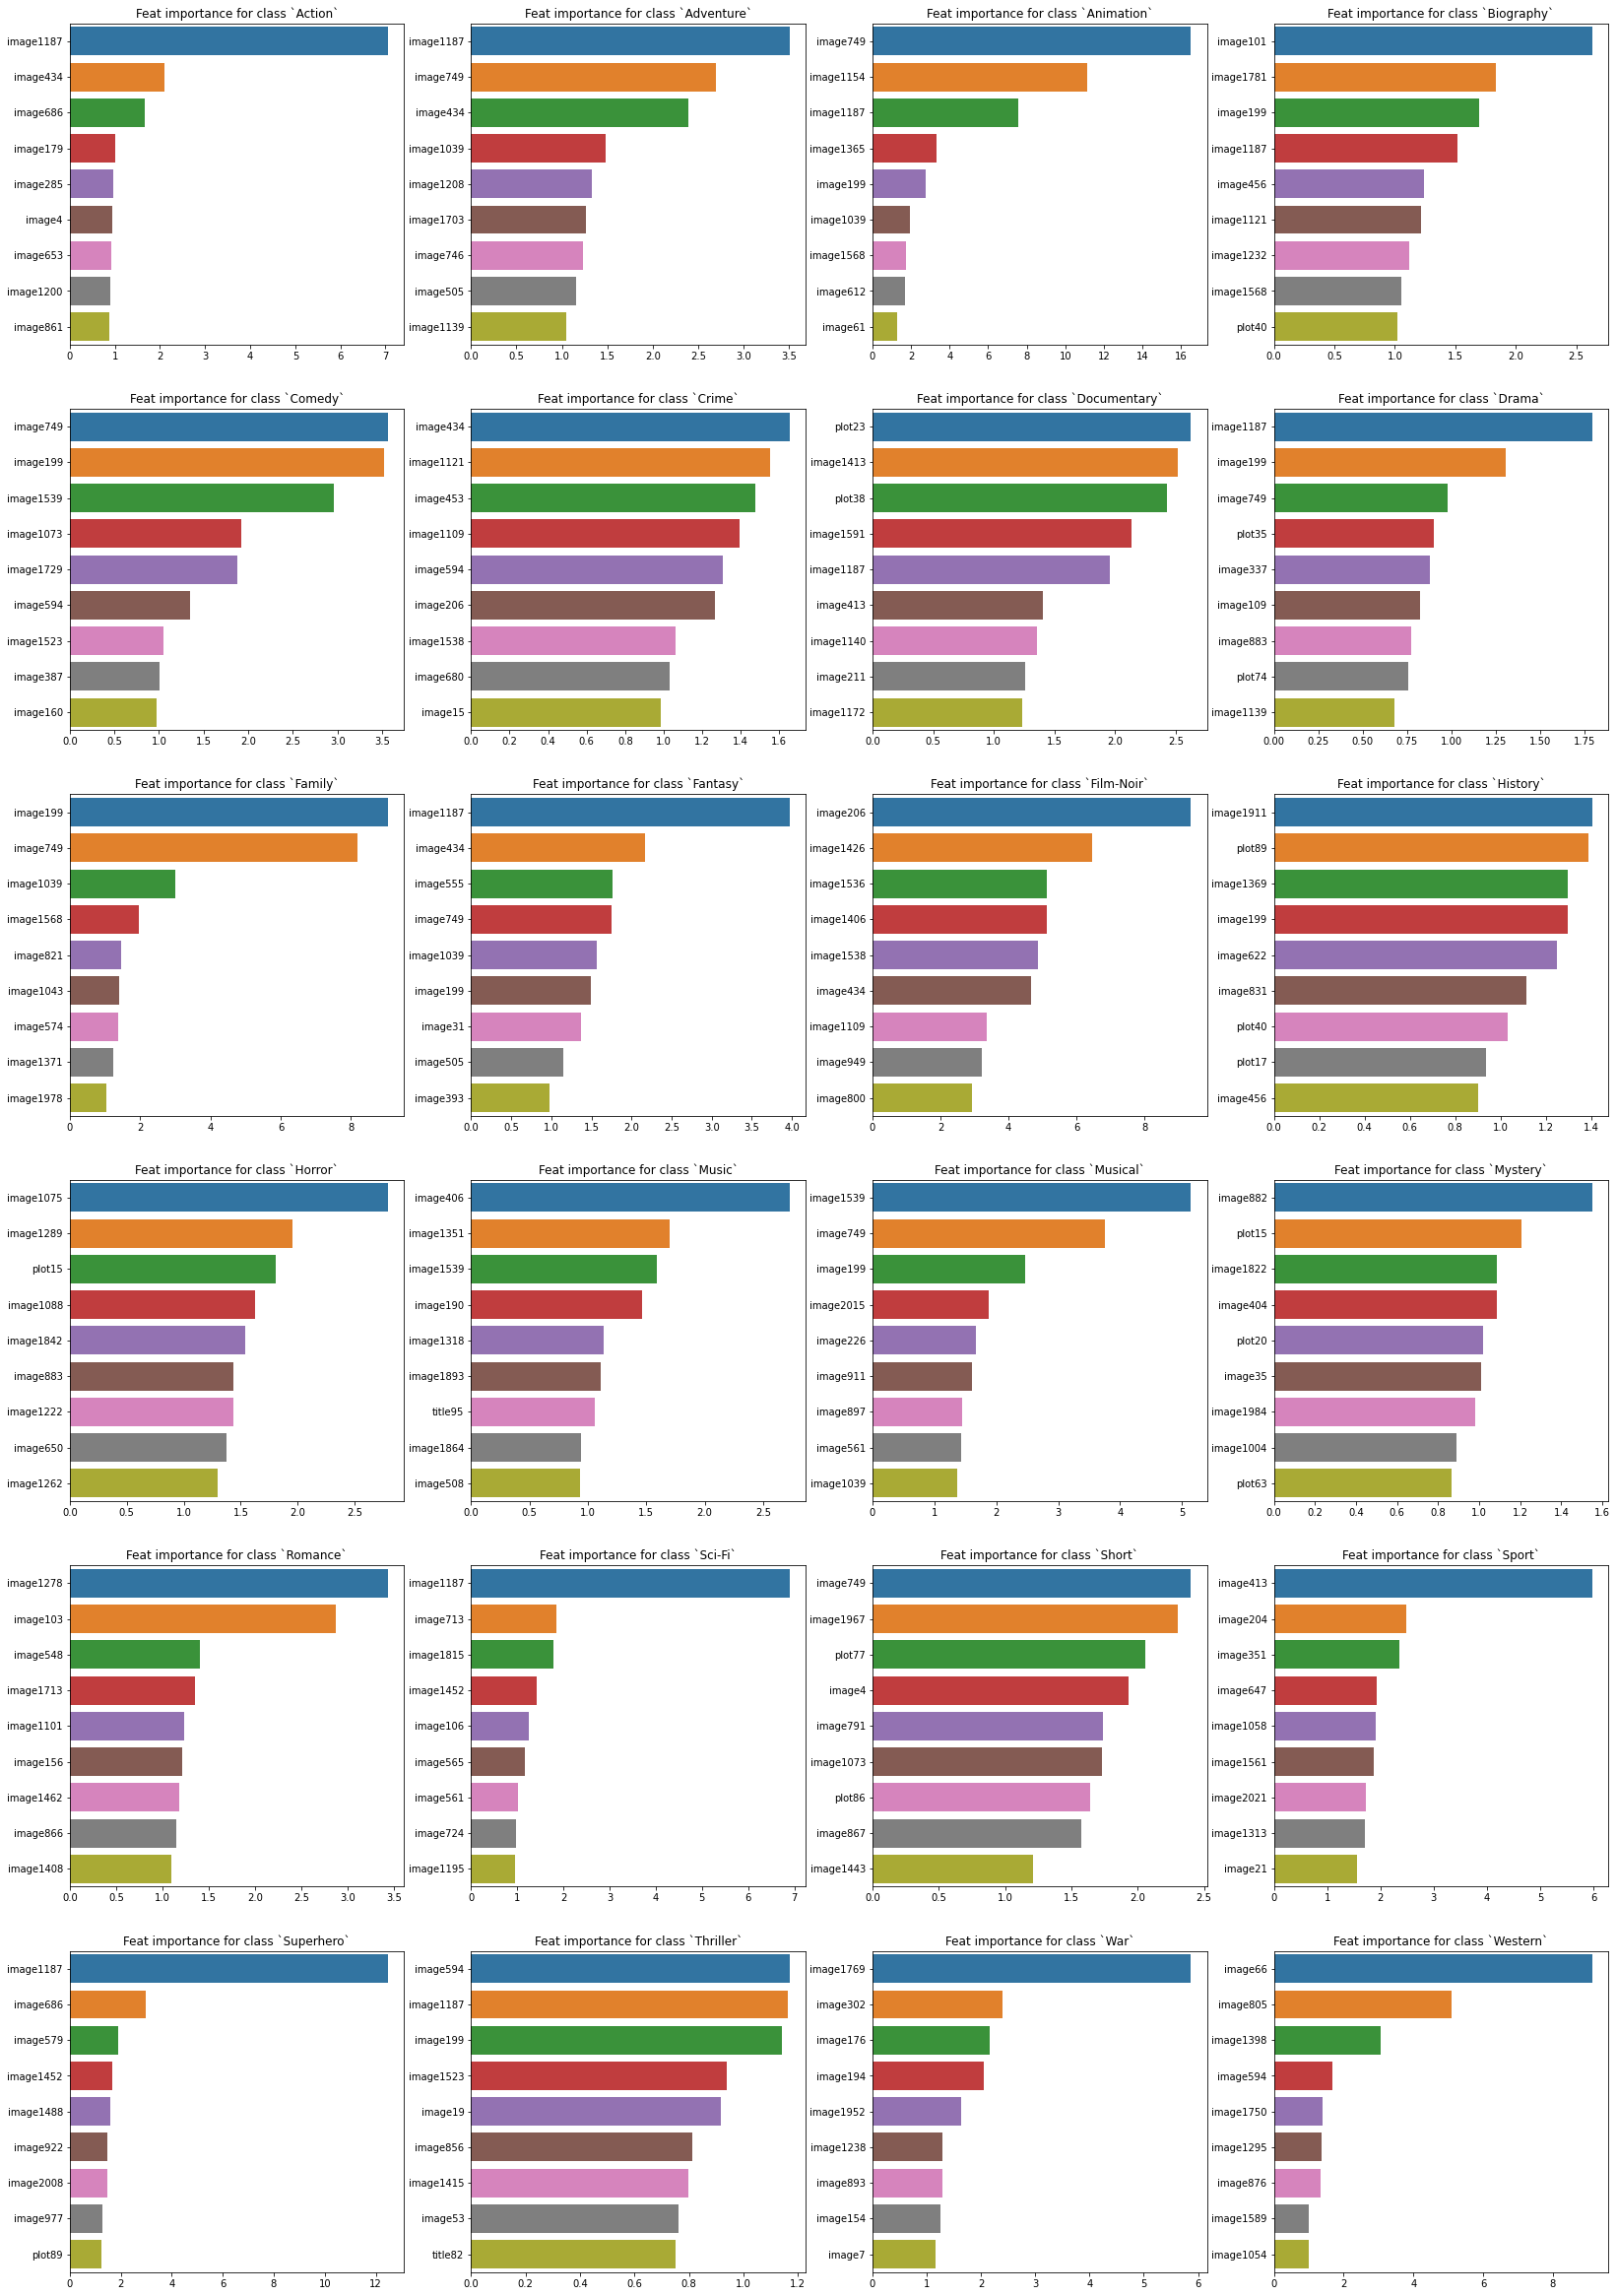

In [63]:
feature_names = [f"image{i}" for i in range(image_embeds.shape[1])] + [f"title{i}" for i in range(tm_title_embeds.shape[1])] + \
    [f"plot{i}" for i in range(tm_plot_embeds.shape[1])]

fig, axs = plt.subplots(6, 4, figsize=(28, 42))
for i in range(6):
    for j in range(4):
        k = i * 4 + j
        inds = models[k].feature_importances_.argsort()[: - 10: - 1]
        sns.barplot(x=models[k].feature_importances_[inds], y=[feature_names[ind] for ind in inds], ax=axs[i][j])
        axs[i][j].set_title(f"Feat importance for class `{classes[k]}`")